In [1]:
# General
import sys
import os.path as op
from time import time
from collections import OrderedDict as od
from glob import glob
import itertools
import warnings
from importlib import reload

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

# Stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.utils.fixes import loguniform
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
# from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, remapping, pop_decoding

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

proj_dir = '/home1/dscho/projects/time_cells'

In [2]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*-Events.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


In [3]:
# Get spike counts in each time bin, for all neurons in the study.
pop_spikes = pop_decoding.load_pop_spikes()

print(pop_spikes)

457 neurons
500 ms time bins
36 trials
160 time bins/trial
pop_spikes: (5760, 460)


In [4]:
def _combine_time_bins(spike_mat, bins=10):
    """Return sum of spikes across trials within each time bin."""
    spike_mat = np.array(spike_mat)
    if len(spike_mat.shape) == 2:
        return np.array([v.sum() for v in np.split(np.sum(spike_mat, axis=0), bins)])
    else:
        return None

In [5]:
np.vander(np.arange(10), 3)

array([[ 0,  0,  1],
       [ 1,  1,  1],
       [ 4,  2,  1],
       [ 9,  3,  1],
       [16,  4,  1],
       [25,  5,  1],
       [36,  6,  1],
       [49,  7,  1],
       [64,  8,  1],
       [81,  9,  1]])

In [29]:
def get_model_formulas_trial(neuron):
    """Define model formulas for single-unit to behavior comparisons.
    
    Parameters
    ----------
    neuron : str
        e.g. '5-2' would be channel 5, unit 2
    """
    time_quad = 'time_step + np.square(time_step)'
    formulas = od([])
    formulas['full'] = "Q('{}') ~ 1 + C(gameState, Sum) + time_bin + C(gameState, Sum):time_bin".format(neuron)
#     formulas['full_subtime'] = "Q('{}') ~ 1 + (time_step * C(gameState))".format(neuron)
#     formulas['full_subgs'] = "Q('{}') ~ 1 + (time_step * C(gameState))".format(neuron)
#     formulas['full_subgs'] = "Q('{}') ~ 1 + (time_step * C(gameState))".format(neuron)
    return formulas

In [20]:
def get_ols_params_trial(neuron,
                   event_spikes,
                   game_states=['Delay1' , 'Encoding', 'Delay2', 'Retrieval'],
                   mod_name='full',
                   regress_trial=False,
                   event_spikes_idx=None):
    """Find the most important time bin.
    Fit firing rates using OLS regression, iteratively removing
    each time step from the data and recording 
    
    Parameters
    ----------
    neuron : str
        e.g. '5-2' would be channel 5, unit 2
    event_spikes : pd.DataFrame
        EventSpikes instance that contains the event_spikes dataframe,
        an expanded version of the behav_events dataframe with columns 
        added for each neuron.
    game_states : list[str]
        Delay1, Encoding, Delay2, or Retrieval.
    regress_trial : bool
        If True, model includes a dummy-coded predictor for each trial.
        If False, no trial predictors are added.
    event_spikes_idx : list
        Only event_spikes rows that correspond to the provided index
        labels are used in the regression model.
    
    Returns
    -------
    model_fits : dict[RegressionResultsWrapper]
        Contains model fits from real and shuffled spike data.
    """
    def _get_params(key):
        """Return param names and weights for param type.

        Parameters
        ----------
        key : str
            Must be 'icpt', 'time', 'place', 'head_direc',
            'base_in_view', 'gold_in_view', 'is_moving', or 'dig_performed'.
        """
        if key == 'icpt':
            output = [[neuron, game_state, mod_name, res.llf, key, 'icpt', params['Intercept']]]
            return output

        elif key == 'time':
            keys = [param for param in params.keys() if 'C(time' in param]
            if len(keys) > 0:
                output = []
                for level in event_spikes.column_map['time']:
                    _p = 'C(time_step, Sum)[S.{}]'.format(level.split('-')[1])
                    if _p in params:
                        output.append([neuron, game_state, mod_name, res.llf, key, level, params[_p]])
                    else:
                        output.append([neuron, game_state, mod_name, res.llf, key, level, -params[keys].sum()])
                return output
            else:
                return None

        elif key == 'place':
            keys = [param for param in params.keys() if 'maze_region' in param]
            if len(keys) > 0:
                output = []
                for level in event_spikes.column_map['place']:
                    _p = 'C(maze_region, Sum)[S.{}]'.format(level.split('-')[1])
                    if _p in params:
                        output.append([neuron, game_state, mod_name, res.llf, key, level, params[_p]])
                    else:
                        output.append([neuron, game_state, mod_name, res.llf, key, level, -params[keys].sum()])
                return output
            else:
                return None

        elif key == 'head_direc':
            keys = [param for param in params.keys() if 'head_direc' in param]
            if len(keys) > 0:
                output = []
                for level in event_spikes.column_map['hd']:
                    _p = 'C(head_direc, Sum)[S.{}]'.format(level.split('-')[1])
                    if _p in params:
                        output.append([neuron, game_state, mod_name, res.llf, key, level, params[_p]])
                    else:
                        output.append([neuron, game_state, mod_name, res.llf, key, level, -params[keys].sum()])
                return output
            else:
                return None

        elif key == 'base_in_view':
            keys = [param for param in params.keys() if 'base_in_view' in param]
            if len(keys) > 0:
                output = [[neuron, game_state, mod_name, res.llf, key, 'base_in_view', -params[keys].sum()]]
                return output
            else:
                return None

        elif key == 'gold_in_view':
            keys = [param for param in params.keys() if 'gold_in_view' in param]
            if len(keys) > 0:
                output = [[neuron, game_state, mod_name, res.llf, key, 'gold_in_view', -params[keys].sum()]]
                return output
            else:
                return None

        elif key == 'is_moving':
            keys = [param for param in params.keys() if 'is_moving' in param]
            if len(keys) > 0:
                output = [[neuron, game_state, mod_name, res.llf, key, 'is_moving', -params[keys].sum()]]
                return output
            else:
                return None

        elif key == 'dig_performed':
            keys = [param for param in params.keys() if 'dig_performed' in param]
            if len(keys) > 0:
                output = [[neuron, game_state, mod_name, res.llf, key, 'dig_performed', -params[keys].sum()]]
                return output
            else:
                return None
            
        elif key in ['time_step', 'np.square(time_step)']:
            if key in params:
                output = [[neuron, game_state, mod_name, res.llf, key, key, params[key]]]
                return output
            else:
                return None
        
        else:
            return None
    
    # Select rows for the chosen game states.
    if type(game_states) == str:
        game_states = [game_states]
        
    if event_spikes_idx is None:
        df = event_spikes.event_spikes.query("(gameState=={})".format(game_states)).copy()
    else:
        df = event_spikes.event_spikes.loc[event_spikes_idx].copy()
    df['gameState'] = df['gameState'].astype(pd.CategoricalDtype(game_states, ordered=True))
    
    # Make sure there are no nans.
    dummys = ['is_moving', 'base_in_view', 'gold_in_view', 'dig_performed']
    df[dummys] = df[dummys].fillna(0)
        
    # Fit the model.
    formulas = get_model_formulas_trial(neuron)
    res = ols(formulas[mod_name], data=df).fit()
    
    return res
    
    # Get model weights.
    params = res.params
    
    keys = ['time']
    output = []
    for key in keys:
        val = _get_params(key)
        if val:
            output.append(val)
    output = pd.DataFrame(np.concatenate(output),
                          columns=['subj_sess_unit', 'gameState', 'mod_name', 'llf', 'cond', 'level', 'weight'])
    output['weight'] = output['weight'].astype(float)
    output['subj_sess_unit'] = output['subj_sess_unit'].apply(lambda x: '-'.join([event_spikes.subj_sess, x]))
    
    return output

In [30]:
subj_sess = 'U530_ses0'
unit = '13-1'
game_states = ['Delay1']

event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)

res = get_ols_params_trial(unit, event_spikes, mod_name='full')

# output = pd.concat((get_ols_params_trial(unit, event_spikes, game_states=game_states, mod_name='full'),
#                     get_ols_params_trial(unit, event_spikes, game_states=game_states, mod_name='full_quad')))
# output

In [31]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              Q('13-1')   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.952
Date:                Mon, 13 Sep 2021   Prob (F-statistic):           6.39e-07
Time:                        17:18:02   Log-Likelihood:                -9435.2
No. Observations:                5760   AIC:                         1.889e+04
Df Residuals:                    5752   BIC:                         1.894e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [ ]:
res.

In [22]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              Q('13-1')   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.952
Date:                Mon, 13 Sep 2021   Prob (F-statistic):           6.39e-07
Time:                        16:46:15   Log-Likelihood:                -9435.2
No. Observations:                5760   AIC:                         1.889e+04
Df Residuals:                    5752   BIC:                         1.894e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [260]:
def get_model_formulas(game_state,
                       neuron,
                       regress_trial=False):
    """Define model formulas for single-unit to behavior comparisons.
    
    Parameters
    ----------
    neuron : str
        e.g. '5-2' would be channel 5, unit 2
    """
    time_quad = 'time_step + np.square(time_step)'
    trial_term = ' + C(trial)' if regress_trial else ''
    formulas = od([])
    if game_state in ['Delay1', 'Delay2']:
        formulas['full']          = "Q('{}') ~ 1 + C(time_step, Sum){}".format(neuron, trial_term)
        formulas['full_quad']     = "Q('{}') ~ 1 + {}               {}".format(neuron, time_quad, trial_term)
        formulas['full_subtime']  = "Q('{}') ~ 1                    {}".format(neuron, trial_term)
    elif game_state == 'Encoding':
        formulas['full']          = "Q('{}') ~ 1 + C(time_step, Sum) + C(maze_region, Sum) + C(head_direc, Sum) + C(is_moving, Sum) + C(base_in_view, Sum) + C(gold_in_view, Sum){}".format(neuron, trial_term)
        formulas['full_quad']     = "Q('{}') ~ 1 + {}                + C(maze_region, Sum) + C(head_direc, Sum) + C(is_moving, Sum) + C(base_in_view, Sum) + C(gold_in_view, Sum){}".format(neuron, time_quad, trial_term)
        formulas['full_subtime']  = "Q('{}') ~ 1                     + C(maze_region, Sum) + C(head_direc, Sum) + C(is_moving, Sum) + C(base_in_view, Sum) + C(gold_in_view, Sum){}".format(neuron, trial_term)
        formulas['full_subplace'] = "Q('{}') ~ 1 + C(time_step, Sum)                       + C(head_direc, Sum) + C(is_moving, Sum) + C(base_in_view, Sum) + C(gold_in_view, Sum){}".format(neuron, trial_term)
        formulas['full_subhd']    = "Q('{}') ~ 1 + C(time_step, Sum) + C(maze_region, Sum)                      + C(is_moving, Sum) + C(base_in_view, Sum) + C(gold_in_view, Sum){}".format(neuron, trial_term)
        formulas['full_submvmt']  = "Q('{}') ~ 1 + C(time_step, Sum) + C(maze_region, Sum) + C(head_direc, Sum)                     + C(base_in_view, Sum) + C(gold_in_view, Sum){}".format(neuron, trial_term)
        formulas['full_subbiv']   = "Q('{}') ~ 1 + C(time_step, Sum) + C(maze_region, Sum) + C(head_direc, Sum) + C(is_moving, Sum)                        + C(gold_in_view, Sum){}".format(neuron, trial_term)
        formulas['full_subgiv']   = "Q('{}') ~ 1 + C(time_step, Sum) + C(maze_region, Sum) + C(head_direc, Sum) + C(is_moving, Sum) + C(base_in_view, Sum)                       {}".format(neuron, trial_term)
    elif game_state == 'Retrieval':
        formulas['full']          = "Q('{}') ~ 1 + C(time_step, Sum) + C(maze_region, Sum) + C(head_direc, Sum) + C(is_moving, Sum) + C(base_in_view, Sum) + C(dig_performed, Sum){}".format(neuron, trial_term)
        formulas['full_quad']     = "Q('{}') ~ 1 + {}                + C(maze_region, Sum) + C(head_direc, Sum) + C(is_moving, Sum) + C(base_in_view, Sum) + C(dig_performed, Sum){}".format(neuron, time_quad, trial_term)
        formulas['full_subtime']  = "Q('{}') ~ 1                     + C(maze_region, Sum) + C(head_direc, Sum) + C(is_moving, Sum) + C(base_in_view, Sum) + C(dig_performed, Sum){}".format(neuron, trial_term)
        formulas['full_subplace'] = "Q('{}') ~ 1 + C(time_step, Sum)                       + C(head_direc, Sum) + C(is_moving, Sum) + C(base_in_view, Sum) + C(dig_performed, Sum){}".format(neuron, trial_term)
        formulas['full_subhd']    = "Q('{}') ~ 1 + C(time_step, Sum) + C(maze_region, Sum)                      + C(is_moving, Sum) + C(base_in_view, Sum) + C(dig_performed, Sum){}".format(neuron, trial_term)
        formulas['full_submvmt']  = "Q('{}') ~ 1 + C(time_step, Sum) + C(maze_region, Sum) + C(head_direc, Sum)                     + C(base_in_view, Sum) + C(dig_performed, Sum){}".format(neuron, trial_term)
        formulas['full_subbiv']   = "Q('{}') ~ 1 + C(time_step, Sum) + C(maze_region, Sum) + C(head_direc, Sum) + C(is_moving, Sum)                        + C(dig_performed, Sum){}".format(neuron, trial_term)
        formulas['full_subdig']   = "Q('{}') ~ 1 + C(time_step, Sum) + C(maze_region, Sum) + C(head_direc, Sum) + C(is_moving, Sum) + C(base_in_view, Sum)                        {}".format(neuron, trial_term)
    return formulas

In [282]:
def get_ols_params(neuron,
                   event_spikes,
                   game_states=['Delay1' , 'Encoding', 'Delay2', 'Retrieval'],
                   mod_name='full',
                   regress_trial=False,
                   event_spikes_idx=None):
    """Find the most important time bin.
    Fit firing rates using OLS regression, iteratively removing
    each time step from the data and recording 
    
    Parameters
    ----------
    neuron : str
        e.g. '5-2' would be channel 5, unit 2
    event_spikes : pd.DataFrame
        EventSpikes instance that contains the event_spikes dataframe,
        an expanded version of the behav_events dataframe with columns 
        added for each neuron.
    game_states : list[str]
        Delay1, Encoding, Delay2, or Retrieval.
    regress_trial : bool
        If True, model includes a dummy-coded predictor for each trial.
        If False, no trial predictors are added.
    event_spikes_idx : list
        Only event_spikes rows that correspond to the provided index
        labels are used in the regression model.
    
    Returns
    -------
    model_fits : dict[RegressionResultsWrapper]
        Contains model fits from real and shuffled spike data.
    """
    def _get_params(key):
        """Return param names and weights for param type.

        Parameters
        ----------
        key : str
            Must be 'icpt', 'time', 'place', 'head_direc',
            'base_in_view', 'gold_in_view', 'is_moving', or 'dig_performed'.
        """
        if key == 'icpt':
            output = [[neuron, game_state, mod_name, res.llf, key, 'icpt', params['Intercept']]]
            return output

        elif key == 'time':
            keys = [param for param in params.keys() if 'C(time' in param]
            if len(keys) > 0:
                output = []
                for level in event_spikes.column_map['time']:
                    _p = 'C(time_step, Sum)[S.{}]'.format(level.split('-')[1])
                    if _p in params:
                        output.append([neuron, game_state, mod_name, res.llf, key, level, params[_p]])
                    else:
                        output.append([neuron, game_state, mod_name, res.llf, key, level, -params[keys].sum()])
                return output
            else:
                return None

        elif key == 'place':
            keys = [param for param in params.keys() if 'maze_region' in param]
            if len(keys) > 0:
                output = []
                for level in event_spikes.column_map['place']:
                    _p = 'C(maze_region, Sum)[S.{}]'.format(level.split('-')[1])
                    if _p in params:
                        output.append([neuron, game_state, mod_name, res.llf, key, level, params[_p]])
                    else:
                        output.append([neuron, game_state, mod_name, res.llf, key, level, -params[keys].sum()])
                return output
            else:
                return None

        elif key == 'head_direc':
            keys = [param for param in params.keys() if 'head_direc' in param]
            if len(keys) > 0:
                output = []
                for level in event_spikes.column_map['hd']:
                    _p = 'C(head_direc, Sum)[S.{}]'.format(level.split('-')[1])
                    if _p in params:
                        output.append([neuron, game_state, mod_name, res.llf, key, level, params[_p]])
                    else:
                        output.append([neuron, game_state, mod_name, res.llf, key, level, -params[keys].sum()])
                return output
            else:
                return None

        elif key == 'base_in_view':
            keys = [param for param in params.keys() if 'base_in_view' in param]
            if len(keys) > 0:
                output = [[neuron, game_state, mod_name, res.llf, key, 'base_in_view', -params[keys].sum()]]
                return output
            else:
                return None

        elif key == 'gold_in_view':
            keys = [param for param in params.keys() if 'gold_in_view' in param]
            if len(keys) > 0:
                output = [[neuron, game_state, mod_name, res.llf, key, 'gold_in_view', -params[keys].sum()]]
                return output
            else:
                return None

        elif key == 'is_moving':
            keys = [param for param in params.keys() if 'is_moving' in param]
            if len(keys) > 0:
                output = [[neuron, game_state, mod_name, res.llf, key, 'is_moving', -params[keys].sum()]]
                return output
            else:
                return None

        elif key == 'dig_performed':
            keys = [param for param in params.keys() if 'dig_performed' in param]
            if len(keys) > 0:
                output = [[neuron, game_state, mod_name, res.llf, key, 'dig_performed', -params[keys].sum()]]
                return output
            else:
                return None
            
        elif key in ['time_step', 'np.square(time_step)']:
            if key in params:
                output = [[neuron, game_state, mod_name, res.llf, key, key, params[key]]]
                return output
            else:
                return None
        
        else:
            return None
    
    # Select rows for the chosen game states.
    if type(game_states) == str:
        game_states = [game_states]
        
    if event_spikes_idx is None:
        df = event_spikes.event_spikes.query("(gameState=={})".format(game_states)).copy()
    else:
        df = event_spikes.event_spikes.loc[event_spikes_idx].copy()
    
    keys = ['icpt', 'time', 'place', 'head_direc', 
            'base_in_view', 'gold_in_view', 'is_moving', 'dig_performed',
            'time_step', 'np.square(time_step)']
    output = []
    for game_state in game_states:
        # For delays, sum spikes across time bins within each time step, within each trial.
        if game_state in ['Delay1', 'Delay2']:
            _df = df.query("(gameState=='{}')".format(game_state)).groupby(['trial', 'time_step']).agg({neuron: np.sum}).reset_index().copy()
        elif game_state in ['Encoding', 'Retrieval']:
            _df = df.query("(gameState=='{}')".format(game_state)).copy()
            # Make sure there are no nans.
            dummys = ['is_moving', 'base_in_view', 'gold_in_view', 'dig_performed']
            _df[dummys] = _df[dummys].fillna(0)
        
        # Fit the model.
        formulas = get_model_formulas(game_state, neuron, regress_trial)
        res = ols(formulas[mod_name], data=_df).fit()
        
        # Get model weights.
        params = res.params
        
        for key in keys:
            val = _get_params(key)
            if val:
                output.append(val)
    output = pd.DataFrame(np.concatenate(output),
                          columns=['subj_sess_unit', 'gameState', 'mod_name', 'llf', 'cond', 'level', 'weight'])
    output['weight'] = output['weight'].astype(float)
    output['subj_sess_unit'] = output['subj_sess_unit'].apply(lambda x: '-'.join([event_spikes.subj_sess, x]))
    
    return output

In [286]:
subj_sess = 'U530_ses0'
unit = '13-1'
game_states = ['Delay1']

event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)

output = pd.concat((get_ols_params(unit, event_spikes, game_states=game_states, mod_name='full'),
                    get_ols_params(unit, event_spikes, game_states=game_states, mod_name='full_quad')))
output

,subj_sess_unit,gameState,mod_name,llf,cond,level,weight
0,U530_ses0-13-1,Delay1,full,-774.048813624579,icpt,icpt,1.963889
1,U530_ses0-13-1,Delay1,full,-774.048813624579,time,time-1,-0.019444
2,U530_ses0-13-1,Delay1,full,-774.048813624579,time,time-2,-0.436111
3,U530_ses0-13-1,Delay1,full,-774.048813624579,time,time-3,-0.019444
4,U530_ses0-13-1,Delay1,full,-774.048813624579,time,time-4,-0.380556
5,U530_ses0-13-1,Delay1,full,-774.048813624579,time,time-5,-0.825000
6,U530_ses0-13-1,Delay1,full,-774.048813624579,time,time-6,-0.325000
7,U530_ses0-13-1,Delay1,full,-774.048813624579,time,time-7,-0.491667
8,U530_ses0-13-1,Delay1,full,-774.048813624579,time,time-8,0.480556
9,U530_ses0-13-1,Delay1,full,-774.048813624579,time,time-9,1.036111


In [7]:
def load_ols_params(ols_pairs,
                    savefile=1,
                    overwrite=0,
                    proj_dir='/home1/dscho/projects/time_cells',
                    verbose=1):
    """Get weights for all unit-to-behavior models, for all neurons."""
    # Get a list of all neurons.
    neurons = ols_pairs['subj_sess_unit'].unique()
    
    # Check if output exists.
    filename = op.join(proj_dir, 'analysis', 'unit_to_behav', 'all_param_weights',
                       'ols_params-{}_units.pkl'.format(neurons.size))
    if op.exists(filename) and not overwrite:
        return dio.open_pickle(filename)
    
    # Get parameters for each neuron, in turn.
    ols_params = []
    for subj_sess_unit in neurons:
        subj_sess = subj_sess_unit.split('-')[0]
        unit = '-'.join(subj_sess_unit.split('-')[1:])

        # Load event_spikes.
        if 'event_spikes' in locals():
            if event_spikes.subj_sess != subj_sess:
                event_spikes = time_bin_analysis.load_event_spikes(subj_sess, proj_dir=proj_dir, verbose=0)
        else:
            event_spikes = time_bin_analysis.load_event_spikes(subj_sess, proj_dir=proj_dir, verbose=0)
        
        ols_params.append(get_ols_params(unit, event_spikes))
    ols_params = pd.concat(ols_params)
    
    # Save output.
    if savefile:
        dio.save_pickle(ols_params, filename, verbose)

    return ols_params

In [58]:
# Load ols_pairs.
filename = op.join(proj_dir, 'analysis', 'unit_to_behav', 'all_units_time',
                   'ols-time_bin-model_pairs-457units.pkl')
ols_pairs = dio.open_pickle(filename)
game_state_cats = pd.CategoricalDtype(['Delay1', 'Encoding', 'Delay2', 'Retrieval'], ordered=True)
ols_pairs['gameState'] = ols_pairs['gameState'].astype(game_state_cats)

print(ols_pairs.shape)

(5027, 29)


In [8]:
savefile = 0
overwrite = 0
verbose = 1

start_time = time()

ols_params = load_ols_params(ols_pairs, savefile=savefile, overwrite=overwrite, verbose=verbose)

print('Done in {:.1f}s'.format(time() - start_time))

Done in 0.1s


In [52]:
pd.concat((df[['subj_sess_unit']], df['weight'].apply(pd.Series)), axis=1)

,subj_sess_unit,_argmin,_min,_argmax,_max,_abs_argmax,_abs_max
0,U518_ses0-11-1,8.0,-0.844444,0.0,0.627778,8.0,-0.844444
1,U518_ses0-13-1,8.0,-0.586111,2.0,0.691667,2.0,0.691667
2,U518_ses0-13-2,8.0,-0.533333,3.0,0.716667,3.0,0.716667
3,U518_ses0-15-1,0.0,-1.227778,3.0,1.383333,3.0,1.383333
4,U518_ses0-16-1,0.0,-1.216667,1.0,1.366667,1.0,1.366667
...,...,...,...,...,...,...,...
452,U540_ses0-6-2,0.0,-0.308333,3.0,0.330556,3.0,0.330556
453,U540_ses0-6-3,2.0,-0.188889,6.0,0.311111,6.0,0.311111
454,U540_ses0-60-1,0.0,-0.091667,8.0,0.102778,8.0,0.102778
455,U540_ses0-63-1,2.0,-0.072222,5.0,0.094444,5.0,0.094444


In [59]:
savefile = 0
overwrite = 0

start_time = time()

def _minmax(vec):
    out = od([])
    out['beta_argmin'] = np.argmin(vec)
    out['beta_min'] = vec[out['beta_argmin']]
    out['beta_argmax'] = np.argmax(vec)
    out['beta_max'] = vec[out['beta_argmax']]
    out['beta_abs_argmax'] = np.argmax(np.abs(vec))
    out['beta_abs_max'] = vec[out['beta_abs_argmax']]
    return out

testvars = ['time', 'place', 'head_direc', 'base_in_view', 'gold_in_view']
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
qry = "(gameState=='{}') & (subj_sess_unit=={}) & (cond=='{}')"
output = []
for testvar in testvars:
    for game_state in game_states:
        neurons = ols_pairs.query("(gameState=='{}') & (testvar=='{}')".format(game_state, testvar))['subj_sess_unit'].unique()
        if neurons.size > 0:
            print('{}, {}, {} units'.format(testvar, game_state, neurons.size))
            df = (ols_params
                  .query(qry.format(game_state, neurons.tolist(), testvar))
                  .groupby('subj_sess_unit')
                  .agg({'weight': lambda x: _minmax(list(x))})
                  .reset_index())
            df = pd.concat((df[['subj_sess_unit']], df['weight'].apply(pd.Series)), axis=1)
            df.insert(1, 'testvar', testvar)
            df.insert(2, 'gameState', game_state)
            output.append(df)
output = pd.concat(output)
ols_pairs = pd.merge(ols_pairs, output, how='left', on=['subj_sess_unit', 'testvar', 'gameState'])
ols_pairs['beta_argmin'] = ols_pairs['beta_argmin'].astype(int)
ols_pairs['beta_argmax'] = ols_pairs['beta_argmax'].astype(int)
ols_pairs['beta_abs_argmax'] = ols_pairs['beta_abs_argmax'].astype(int)
ols_pairs['testvar'] = ols_pairs['testvar'].astype(pd.CategoricalDtype(['time', 'place', 'head_direc', 'base_in_view', 'gold_in_view'], ordered=True))
ols_pairs['gameState'] = ols_pairs['gameState'].astype(pd.CategoricalDtype(['Delay1', 'Encoding', 'Delay2', 'Retrieval'], ordered=True))

# Save ols_pairs.
filename = op.join(proj_dir, 'analysis', 'unit_to_behav', 'all_units_time',
                   'ols-time_bin-model_pairs-457units.pkl')
if savefile:
    if overwrite:
        dio.save_pickle(ols_pairs, filename)

print('Done in {:.1f}s'.format(time() - start_time))

time, Delay1, 457 units
time, Encoding, 457 units
time, Delay2, 457 units
time, Retrieval, 457 units
place, Encoding, 457 units
place, Retrieval, 457 units
head_direc, Encoding, 457 units
head_direc, Retrieval, 457 units
base_in_view, Encoding, 457 units
base_in_view, Retrieval, 457 units
gold_in_view, Encoding, 457 units
Done in 3.3s


In [67]:
keep_cols = ['subj_sess_unit', 'roi', 'gameState', 'testvar', 'z_lr', 'fr_mean', 'sparsity',
             'fr_max_ind', 'fr_max_ind10', 'fr_max_ind5', 'fr_max_ind4', 'sig', 'sig_holm',
             'beta_argmin', 'beta_min', 'beta_argmax', 'beta_max', 'beta_abs_argmax', 'beta_abs_max']
ols_pairs.query("(subj_sess_unit=='U518_ses1-43-2') & (gameState=='Encoding')")[keep_cols]

,subj_sess_unit,roi,gameState,testvar,z_lr,fr_mean,sparsity,fr_max_ind,fr_max_ind10,fr_max_ind5,fr_max_ind4,sig,sig_holm,beta_argmin,beta_min,beta_argmax,beta_max,beta_abs_argmax,beta_abs_max
607,U518_ses1-43-2,PHG,Encoding,time,-0.164419,1.277451,0.800861,2,0,2,2,False,False,8,-0.244082,0,0.254056,0,0.254056
608,U518_ses1-43-2,PHG,Encoding,place,12.444628,1.277451,0.800861,2,0,2,2,True,True,9,-0.269256,2,1.284632,2,1.284632
609,U518_ses1-43-2,PHG,Encoding,head_direc,7.474180,1.277451,0.800861,2,0,2,2,True,True,0,-0.349371,5,0.511337,5,0.511337
610,U518_ses1-43-2,PHG,Encoding,base_in_view,5.337295,1.277451,0.800861,2,0,2,2,True,True,0,0.246140,0,0.246140,0,0.246140
611,U518_ses1-43-2,PHG,Encoding,gold_in_view,0.178082,1.277451,0.800861,2,0,2,2,False,False,0,0.054555,0,0.054555,0,0.054555


In [123]:
ols_params.query("(subj_sess_unit=='U518_ses1-73-1') & (gameState=='Delay1')")

,subj_sess_unit,gameState,cond,level,weight
0,U518_ses1-73-1,Delay1,icpt,icpt,5.017647
1,U518_ses1-73-1,Delay1,time,time-1,0.041176
2,U518_ses1-73-1,Delay1,time,time-2,0.482353
3,U518_ses1-73-1,Delay1,time,time-3,-0.547059
4,U518_ses1-73-1,Delay1,time,time-4,-0.605882
5,U518_ses1-73-1,Delay1,time,time-5,0.158824
6,U518_ses1-73-1,Delay1,time,time-6,0.394118
7,U518_ses1-73-1,Delay1,time,time-7,-0.341176
8,U518_ses1-73-1,Delay1,time,time-8,0.482353
9,U518_ses1-73-1,Delay1,time,time-9,-0.252941


In [158]:
_combine_time_bins(ols_pairs.query("(gameState==['Delay1', 'Delay2'])").iloc[idx].iloc[1]['spike_mat'])

array([172, 187, 152, 150, 176, 184, 159, 187, 162, 177])

In [165]:
# What percent of significant neurons are best explained
# by an increase in firing rate over the mean across levels
# for a given testvar (i.e. a positive abs_beta_argmax)?
def _over_under0(x):
    over = np.sum(x>0)
    return '{}/{} ({:.1%}); {}/{} ({:.1%}), p = {:.6f}'.format(over, len(x), over/len(x), 
                                                           over, n_units, over/n_units,
                                                           stats.binom_test(over, n_units, p=0.025, alternative='greater'))

n_units = ols_pairs['subj_sess_unit'].unique().size
ols_pairs.query("(sig==True)").groupby(['testvar', 'gameState'], observed=True)['beta_abs_max'].apply(_over_under0)

testvar       gameState
time          Delay1       58/73 (79.5%); 58/457 (12.7%), p = 0.000000
              Encoding     52/88 (59.1%); 52/457 (11.4%), p = 0.000000
              Delay2       46/63 (73.0%); 46/457 (10.1%), p = 0.000000
              Retrieval     44/80 (55.0%); 44/457 (9.6%), p = 0.000000
place         Encoding     47/71 (66.2%); 47/457 (10.3%), p = 0.000000
              Retrieval    54/84 (64.3%); 54/457 (11.8%), p = 0.000000
head_direc    Encoding      30/49 (61.2%); 30/457 (6.6%), p = 0.000002
              Retrieval     26/46 (56.5%); 26/457 (5.7%), p = 0.000117
base_in_view  Encoding      23/44 (52.3%); 23/457 (5.0%), p = 0.001448
              Retrieval     12/50 (24.0%); 12/457 (2.6%), p = 0.471968
gold_in_view  Encoding     59/88 (67.0%); 59/457 (12.9%), p = 0.000000
Name: beta_abs_max, dtype: object

In [ ]:
def mean_sem(x):
    if len(x) > 1:
        return '{:.1f} ± {:.1f}'.format(np.mean(x), stats.sem(x))
    else:
        return '{:.1f}'.format(np.mean(x))

idx_to_time = ols_params.query("(cond=='time')").reset_index(drop=True).drop_duplicates('level')['level'].to_dict()
df = (ols_pairs
      .query("(sig==True) & (beta_abs_max>0) & (testvar=='time')")
      .groupby(['gameState', 'beta_abs_argmax'], observed=True)
      .agg({'subj_sess_unit': len, 'z_lr': mean_sem})
      .reset_index())
df.insert(2, 'level', df['beta_abs_argmax'].apply(lambda x: idx_to_time[x][5:]))
df

In [319]:
def mean_sem(x):
    if len(x) > 1:
        return '{:.1f} ± {:.1f}'.format(np.mean(x), stats.sem(x))
    else:
        return '{:.1f}'.format(np.mean(x))

idx_to_time = ols_params.query("(cond=='time')").reset_index(drop=True).drop_duplicates('level')['level'].to_dict()
idx_to_place = ols_params.query("(cond=='place')").reset_index(drop=True).drop_duplicates('level')['level'].to_dict()
idx_to_hd = ols_params.query("(cond=='head_direc')").reset_index(drop=True).drop_duplicates('level')['level'].to_dict()
idx_to_giv = ols_params.query("(cond=='gold_in_view')").reset_index(drop=True).drop_duplicates('level')['level'].to_dict()
idx_to_biv = ols_params.query("(cond=='base_in_view')").reset_index(drop=True).drop_duplicates('level')['level'].to_dict()

df_time = (ols_pairs
           .query("(sig==True) & (beta_abs_max>0) & (testvar=='time')")
           .groupby(['gameState', 'beta_abs_argmax'], observed=True)
           .agg({'subj_sess_unit': len, 'z_lr': mean_sem})
           .reset_index())
df_time.insert(0, 'testvar', 'time')
df_time.insert(3, 'level', df_time['beta_abs_argmax'].apply(lambda x: idx_to_time[x][5:]))

df_place = (ols_pairs
            .query("(sig==True) & (beta_abs_max>0) & (testvar=='place')")
            .groupby(['gameState', 'beta_abs_argmax'], observed=True)
            .agg({'subj_sess_unit': len, 'z_lr': mean_sem})
            .reset_index())
df_place.insert(0, 'testvar', 'place')
df_place.insert(3, 'level', df_place['beta_abs_argmax'].apply(lambda x: idx_to_place[x][6:]))

df_hd = (ols_pairs
         .query("(sig==True) & (beta_abs_max>0) & (testvar=='head_direc')")
         .groupby(['gameState', 'beta_abs_argmax'], observed=True)
         .agg({'subj_sess_unit': len, 'z_lr': mean_sem})
         .reset_index())
df_hd.insert(0, 'testvar', 'head_direc')
df_hd.insert(3, 'level', df_hd['beta_abs_argmax'].apply(lambda x: idx_to_hd[x][3:]))

df_giv = (ols_pairs
          .query("(sig==True) & (beta_abs_max>0) & (testvar=='gold_in_view')")
          .groupby(['gameState', 'beta_abs_argmax'], observed=True)
          .agg({'subj_sess_unit': len, 'z_lr': mean_sem})
          .reset_index())
df_giv.insert(0, 'testvar', 'gold_in_view')
df_giv.insert(3, 'level', df_giv['beta_abs_argmax'].apply(lambda x: idx_to_giv[x]))

df_biv = (ols_pairs
          .query("(sig==True) & (beta_abs_max>0) & (testvar=='base_in_view')")
          .groupby(['gameState', 'beta_abs_argmax'], observed=True)
          .agg({'subj_sess_unit': len, 'z_lr': mean_sem})
          .reset_index())
df_biv.insert(0, 'testvar', 'base_in_view')
df_biv.insert(3, 'level', df_biv['beta_abs_argmax'].apply(lambda x: idx_to_biv[x]))

df = pd.concat((df_time, df_place, df_hd, df_giv, df_biv)).reset_index(drop=True)
df

,testvar,gameState,beta_abs_argmax,level,subj_sess_unit,z_lr
0,time,Delay1,0,1,22,4.8 ± 0.7
1,time,Delay1,1,2,10,2.8 ± 0.2
2,time,Delay1,2,3,4,2.8 ± 0.3
3,time,Delay1,3,4,6,2.6 ± 0.3
4,time,Delay1,4,5,4,2.6 ± 0.1
5,time,Delay1,6,7,3,2.4 ± 0.1
6,time,Delay1,7,8,1,4.8
7,time,Delay1,8,9,4,3.2 ± 0.8
8,time,Delay1,9,10,4,3.0 ± 0.4
9,time,Encoding,0,1,21,4.7 ± 0.4


In [311]:
def mean_sem(x):
    if len(x) > 1:
        return '{:.1f} ± {:.1f}'.format(np.mean(x), stats.sem(x))
    else:
        return '{:.1f}'.format(np.mean(x))

idx_to_place = ols_params.query("(cond=='place')").reset_index(drop=True).drop_duplicates('level')['level'].to_dict()
df = (ols_pairs
      .query("(sig==True) & (beta_abs_max>0) & (testvar=='place')")
      .groupby(['gameState', 'beta_abs_argmax'], observed=True)
      .agg({'subj_sess_unit': len, 'z_lr': mean_sem})
      .reset_index())
df.insert(2, 'level', df['beta_abs_argmax'].apply(lambda x: idx_to_place[x][6:]))
df

,gameState,beta_abs_argmax,level,subj_sess_unit,z_lr
0,Encoding,0,Base,11,3.5 ± 0.4
1,Encoding,1,C_Hall,3,2.6 ± 0.5
2,Encoding,2,NE_Hall,3,6.8 ± 2.8
3,Encoding,3,NE_Room,8,2.5 ± 0.2
4,Encoding,4,NW_Hall,4,3.0 ± 0.5
5,Encoding,5,NW_Room,3,2.0 ± 0.0
6,Encoding,6,N_Passage,4,2.6 ± 0.5
7,Encoding,7,SE_Hall,5,4.0 ± 0.7
8,Encoding,8,SE_Room,1,2.0
9,Encoding,9,SW_Hall,1,2.3


In [310]:
def mean_sem(x):
    if len(x) > 1:
        return '{:.1f} ± {:.1f}'.format(np.mean(x), stats.sem(x))
    else:
        return '{:.1f}'.format(np.mean(x))

idx_to_hd = ols_params.query("(cond=='head_direc')").reset_index(drop=True).drop_duplicates('level')['level'].to_dict()
df = (ols_pairs
      .query("(sig==True) & (beta_abs_max>0) & (testvar=='head_direc')")
      .groupby(['gameState', 'beta_abs_argmax'], observed=True)
      .agg({'subj_sess_unit': len, 'z_lr': mean_sem})
      .reset_index())
df.insert(2, 'level', df['beta_abs_argmax'].apply(lambda x: idx_to_hd[x][3:]))
df

,gameState,beta_abs_argmax,level,subj_sess_unit,z_lr
0,Encoding,0,E,3,6.0 ± 2.3
1,Encoding,1,N,1,2.5
2,Encoding,2,NE,7,3.3 ± 0.3
3,Encoding,3,NW,4,2.8 ± 0.3
4,Encoding,4,S,3,3.4 ± 0.9
5,Encoding,5,SE,5,4.2 ± 1.0
6,Encoding,6,SW,7,3.6 ± 0.9
7,Retrieval,0,E,4,4.4 ± 0.8
8,Retrieval,1,N,4,2.5 ± 0.4
9,Retrieval,2,NE,8,3.2 ± 0.4


In [316]:
def mean_sem(x):
    if len(x) > 1:
        return '{:.1f} ± {:.1f}'.format(np.mean(x), stats.sem(x))
    else:
        return '{:.1f}'.format(np.mean(x))

idx_to_hd = ols_params.query("(cond=='gold_in_view')").reset_index(drop=True).drop_duplicates('level')['level'].to_dict()
df = (ols_pairs
      .query("(sig==True) & (beta_abs_max>0) & (testvar=='gold_in_view')")
      .groupby(['gameState', 'beta_abs_argmax'], observed=True)
      .agg({'subj_sess_unit': len, 'z_lr': mean_sem})
      .reset_index())
df.insert(2, 'level', df['beta_abs_argmax'].apply(lambda x: idx_to_hd[x]))
df

,gameState,beta_abs_argmax,level,subj_sess_unit,z_lr
0,Encoding,0,gold_in_view,59,5.5 ± 0.6


In [218]:
# Delay1 time cells with peak firing >2s.
obs = 58 - 32
exp = n_units * 0.05 * 0.5 * 0.8
ctab = np.array([[obs, n_units-obs],
                 [exp, n_units-exp]])
print(ctab)
stats.chi2_contingency(ctab)[:2]

[[ 26.   431.  ]
 [  9.14 447.86]]


(7.44442409101634, 0.006363327738873183)

In [219]:
# Delay2 time cells with peak firing >2s.
obs = 46 - 31
exp = n_units * 0.05 * 0.5 * 0.8
ctab = np.array([[obs, n_units-obs],
                 [exp, n_units-exp]])
print(ctab)
stats.chi2_contingency(ctab)[:2]

[[ 15.   442.  ]
 [  9.14 447.86]]


(1.0049854709372097, 0.3161071694555897)

In [220]:
# Encoding time cells with peak firing >3s.
obs = 52 - 21
exp = n_units * 0.05 * 0.5 * 0.9
ctab = np.array([[obs, n_units-obs],
                 [exp, n_units-exp]])
print(ctab)
stats.chi2_contingency(ctab)[:2]

[[ 31.     426.    ]
 [ 10.2825 446.7175]]


(9.863026965765991, 0.0016863342530752375)

In [221]:
# Retrieval time cells with peak firing >3s.
obs = 44 - 15
exp = n_units * 0.05 * 0.5 * 0.9
ctab = np.array([[obs, n_units-obs],
                 [exp, n_units-exp]])
print(ctab)
stats.chi2_contingency(ctab)[:2]

[[ 29.     428.    ]
 [ 10.2825 446.7175]]


(8.349955175889244, 0.003856968451074293)

In [175]:
peak_counts = ols_pairs.query("(sig==True) & (beta_abs_max>0)").groupby(['testvar', 'gameState', 'beta_abs_argmax'], observed=True).size().reset_index()
peak_counts.rename(columns={0: 'n'}, inplace=True)
peak_counts

,testvar,gameState,beta_abs_argmax,n
0,time,Delay1,0,22
1,time,Delay1,1,10
2,time,Delay1,2,4
3,time,Delay1,3,6
4,time,Delay1,4,4
5,time,Delay1,6,3
6,time,Delay1,7,1
7,time,Delay1,8,4
8,time,Delay1,9,4
9,time,Encoding,0,21


In [321]:
ols_pairs.columns

Index(['subj', 'subj_sess', 'subj_sess_unit', 'neuron', 'hem', 'roi',
       'roi_gen2', 'roi_gen3', 'roi_gen4', 'roi_gen5', 'gameState', 'testvar',
       'full', 'llf_full', 'lr', 'z_lr', 'emp_pval', 'spike_mat', 'mean_frs',
       'sem_frs', 'fr_mean', 'fr_max', 'fr_max_ind', 'fr_max_ind4',
       'fr_max_ind5', 'fr_max_ind10', 'sparsity', 'sig', 'sig_holm',
       'beta_argmin', 'beta_min', 'beta_argmax', 'beta_max', 'beta_abs_argmax',
       'beta_abs_max'],
      dtype='object')

In [322]:
all_time_cells = ols_pairs.query("(testvar=='time') & (sig==True) & (beta_abs_max>0)")['subj_sess_unit'].unique()
print(all_time_cells.size)

155


In [ ]:
ols_pairs.query("(testvar=='time') & (sig==True) & (beta_abs_max>0)").sort_values(['beta_abs_argmax', 'z_lr'])

In [328]:
all_time_cells = (ols_pairs
                  .query("(testvar=='time') & (sig==True) & (beta_abs_max>0)")
                  .sort_values('z_lr', ascending=0)
                  .drop_duplicates('subj_sess_unit')
                  .sort_values(['gameState', 'beta_abs_argmax', 'z_lr'], ascending=[1, 1, 0])
                  .reset_index(drop=True)['subj_sess_unit'].values)
all_time_cells

array(['U518_ses0-73-1', 'U537_ses0-24-1', 'U518_ses0-4-1',
       'U536_ses0-60-1', 'U518_ses1-4-1', 'U536_ses0-76-1',
       'U518_ses0-32-1', 'U526_ses0-21-1', 'U536_ses0-9-1',
       'U532_ses0-5-1', 'U536_ses0-20-2', 'U536_ses0-18-1',
       'U518_ses1-15-2', 'U536_ses0-59-1', 'U536_ses0-8-1',
       'U530_ses0-20-1', 'U518_ses0-16-1', 'U536_ses0-23-1',
       'U518_ses0-78-2', 'U527_ses0-13-2', 'U536_ses0-39-3',
       'U530_ses0-67-1', 'U518_ses0-78-3', 'U526_ses0-41-2',
       'U536_ses0-36-1', 'U532_ses0-3-2', 'U530_ses1-71-3',
       'U532_ses0-45-3', 'U518_ses0-15-1', 'U536_ses0-20-1',
       'U532_ses0-6-1', 'U540_ses0-36-1', 'U536_ses0-22-1',
       'U540_ses0-46-1', 'U532_ses0-4-1', 'U518_ses1-43-3',
       'U521_ses0-19-1', 'U530_ses1-16-3', 'U530_ses0-48-3',
       'U530_ses0-13-1', 'U532_ses0-21-1', 'U536_ses0-66-1',
       'U540_ses0-19-1', 'U530_ses0-5-1', 'U532_ses0-4-3',
       'U530_ses1-80-1', 'U532_ses0-21-2', 'U532_ses0-5-8',
       'U527_ses0-44-2', 'U532_ses0

In [331]:
(pop_spikes
 .combine_time_bins(time_step_size=1000)
 .groupby(['iGameStateTime'], observed=True)
 [all_time_cells].mean().T)

iGameStateTime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
U518_ses0-73-1,9.583333,6.888889,6.250000,4.638889,5.527778,4.250000,4.666667,4.083333,4.527778,4.361111,4.000000,3.638889,3.944444,3.638889,3.777778,4.777778,5.222222,4.666667,4.305556,4.694444,4.416667,5.000000,4.972222,4.472222,4.583333,3.777778,4.361111,3.944444,4.111111,5.055556,5.111111,5.222222,5.027778,4.722222,4.361111,4.611111,4.027778,4.500000,4.527778,4.111111,10.111111,5.027778,5.861111,5.583333,5.666667,5.583333,4.583333,5.111111,5.138889,4.333333,3.638889,3.527778,4.111111,3.833333,5.055556,5.388889,5.916667,6.416667,7.138889,6.000000,5.388889,5.555556,4.611111,4.583333,4.111111,4.444444,4.805556,3.777778,3.805556,4.055556,3.361111,3.722222,3.944444,3.861111,3.416667,3.277778,3.972222,3.694444,4.138889,3.333333
U537_ses0-24-1,1.694444,0.500000,0.388889,0.444444,0.805556,0.388889,0.416667,0.583333,0.194444,0.500000,1.666667,1.472222,1.583333,1.361111,1.500000,1.194444,0.833333,1.444444,1.638889,1.555556,1.416667,1.805556,2.500000,2.361111,1.888889,2.527778,2.638889,2.083333,1.750000,2.750000,2.138889,1.194444,2.472222,2.833333,2.611111,1.972222,2.611111,1.750000,2.250000,2.388889,1.861111,1.805556,1.166667,0.861111,0.916667,0.444444,0.583333,0.138889,0.333333,0.555556,1.527778,2.500000,1.527778,1.277778,0.916667,0.555556,1.750000,1.805556,1.333333,1.805556,1.750000,2.694444,1.666667,2.361111,1.750000,1.000000,1.777778,1.888889,1.750000,2.194444,1.444444,0.944444,1.777778,1.916667,1.444444,1.611111,2.277778,2.250000,1.694444,2.361111
U518_ses0-4-1,10.166667,7.027778,6.166667,5.916667,5.722222,4.916667,6.250000,4.972222,4.972222,5.916667,4.055556,4.138889,3.944444,4.611111,4.416667,4.500000,5.111111,3.833333,3.305556,4.027778,3.833333,4.305556,3.833333,3.666667,3.666667,4.277778,3.833333,3.888889,3.500000,4.472222,4.305556,3.861111,4.138889,4.194444,4.555556,4.527778,4.361111,4.722222,4.138889,5.250000,9.638889,5.166667,6.416667,7.055556,5.638889,6.027778,6.444444,7.000000,5.888889,6.111111,3.388889,4.138889,4.166667,3.888889,3.555556,5.027778,3.972222,3.527778,3.833333,4.166667,4.555556,3.694444,3.833333,3.916667,3.555556,3.583333,4.416667,3.694444,4.138889,4.361111,4.777778,3.805556,4.333333,4.027778,4.333333,4.194444,4.333333,4.472222,5.361111,4.361111
U536_ses0-60-1,3.000000,2.555556,1.444444,1.194444,0.944444,1.027778,1.000000,1.083333,1.416667,1.361111,1.194444,2.305556,1.583333,1.333333,1.166667,0.583333,1.000000,0.722222,1.277778,1.583333,1.416667,1.388889,1.388889,1.166667,1.555556,1.194444,0.805556,1.194444,1.055556,1.166667,1.527778,1.500000,1.027778,1.305556,1.333333,1.000000,1.027778,1.111111,1.194444,1.722222,1.416667,1.333333,1.027778,1.777778,1.611111,1.750000,1.111111,1.083333,1.000000,1.194444,0.750000,2.083333,1.500000,1.444444,1.305556,1.388889,1.361111,1.583333,2.138889,1.166667,1.333333,1.666667,1.694444,1.444444,1.666667,1.250000,1.861111,1.722222,1.166667,1.388889,1.694444,1.194444,1.500000,1.972222,1.805556,1.305556,1.861111,1.861111,1.194444,1.500000
U518_ses1-4-1,13.194444,9.805556,8.277778,8.861111,7.750000,9.555556,9.500000,9.194444,10.222222,8.583333,8.388889,7.555556,8.166667,8.194444,8.027778,7.722222,6.972222,8.194444,7.361111,7.722222,7.694444,8.527778,6.527778,7.583333,7.694444,6.583333,8.194444,7.361111,7.583333,8.472222,6.611111,9.722222,8.388889,8.805556,9.416667,7.972222,8.166667,8.083333,10.277778,8.138889,11.388889,8.222222,7.694444,7.472222,7.916667,7.111111,8.944444,9.694444,7.944444,8.472222,6.583333,7.416667,7.111111,7.138889,8.527778,8.027778,7.638889,8.055556,7.805556,7.500000,9.222222,7.805556,7.555556,7.138889,8.194444,7.388889,8.805556,8.333333,8.777778,8.777778,8.694444,8.250000,8.027778,7.638889,9.138889,8.388889,8.222222,7.500000,9.750000,8.472222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [327]:
(ols_pairs
 .query("(testvar=='time') & (sig==True) & (beta_abs_max>0)")
 .sort_values('z_lr', ascending=0)
 .drop_duplicates('subj_sess_unit')
 .sort_values(['gameState', 'beta_abs_argmax', 'z_lr'], ascending=[1, 1, 0])
 .reset_index(drop=True)['subj_sess_unit'].values)

,subj,subj_sess,subj_sess_unit,neuron,hem,roi,roi_gen2,roi_gen3,roi_gen4,roi_gen5,gameState,testvar,full,llf_full,lr,z_lr,emp_pval,spike_mat,mean_frs,sem_frs,fr_mean,fr_max,fr_max_ind,fr_max_ind4,fr_max_ind5,fr_max_ind10,sparsity,sig,sig_holm,beta_argmin,beta_min,beta_argmax,beta_max,beta_abs_argmax,beta_abs_max
264,U518,U518_ses0,U518_ses0-73-1,73-1,L,TPO,Cortex,Cortex,Cortex,Temporal,Delay1,time,full,-968.113652,68.076862,14.359388,0.000999,"[[1, 4, 1, 2, 4, 4, 13, 1, 2, 4, 0, 0, 5, 2, 4...","[5.833333333333333, 13.333333333333334, 7.6111...","[0.7099072150416941, 1.1737877907772671, 1.254...",5.477778,13.333333,1,0,0,0,0.874796,True,True,7,-1.394444,0,4.105556,0,4.105556
4301,U537,U537_ses0,U537_ses0-24-1,24-1,R,AH,MTL,Hippocampus,Hippocampus,Hippocampus,Delay1,time,full,-522.630012,49.414014,10.096879,0.000999,"[[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[2.6666666666666665, 0.7222222222222222, 0.666...","[0.4976133515281193, 0.21310669177932628, 0.22...",0.591667,2.666667,0,0,0,0,0.574437,True,True,8,-0.397222,0,1.102778,0,1.102778
209,U518,U518_ses0,U518_ses0-4-1,4-1,R,EC,MTL,MTL,MTL,MTL,Delay1,time,full,-1012.278433,44.774183,9.282328,0.000999,"[[0, 8, 8, 2, 2, 7, 3, 5, 5, 5, 4, 1, 4, 12, 5...","[6.555555555555555, 13.777777777777779, 7.5, 6...","[0.8604580216690839, 1.6518921863773262, 1.155...",6.202778,13.777778,1,0,0,0,0.909452,True,True,5,-1.286111,0,3.963889,0,3.963889
3982,U536,U536_ses0,U536_ses0-60-1,60-1,R,OF,Cortex,Cortex,Frontal,Frontal,Delay1,time,full,-759.106986,38.159839,7.487863,0.000999,"[[1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,...","[2.4444444444444446, 3.5555555555555554, 3.333...","[0.5109040298232088, 0.873275574648058, 0.7559...",1.502778,3.555556,1,0,0,0,0.799719,True,True,4,-0.558333,0,1.497222,0,1.497222
506,U518,U518_ses1,U518_ses1-4-1,4-1,R,EC,MTL,MTL,MTL,MTL,Delay1,time,full,-990.006516,36.758947,7.112284,0.000999,"[[6, 10, 3, 9, 12, 6, 8, 5, 8, 4, 6, 5, 8, 5, ...","[12.764705882352942, 14.235294117647058, 9.764...","[0.925051256978859, 1.1508803291993435, 0.9802...",9.582353,14.235294,1,0,0,0,0.972147,True,True,4,-1.847059,0,3.917647,0,3.917647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2152,U530,U530_ses0,U530_ses0-70-1,70-1,L,A,MTL,MTL,MTL,MTL,Retrieval,time,full,-3029.466745,20.290440,2.115763,0.033966,"[[0, 1, 4, 1, 1, 0, 1, 0, 1, 5, 0, 2, 0, 0, 1,...","[1.8333333333333333, 1.6666666666666667, 1.722...","[0.4013864859597432, 0.31370798270477335, 0.35...",1.644444,2.388889,53,3,3,8,0.959790,True,False,0,-0.129638,8,0.195278,8,0.195278
997,U526,U526_ses0,U526_ses0-12-1,12-1,L,A,MTL,MTL,MTL,MTL,Retrieval,time,full,-3076.884523,21.971578,1.906242,0.041958,"[[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1,...","[1.3333333333333333, 1.3888888888888888, 0.666...","[0.38214100281407387, 0.33636190302410357, 0.1...",1.161111,2.111111,53,3,4,8,0.900639,True,False,2,-0.181501,8,0.223469,8,0.223469
1415,U527,U527_ses0,U527_ses0-41-1,41-1,R,EC,MTL,MTL,MTL,MTL,Retrieval,time,full,-4458.220782,41.228947,3.790544,0.004995,"[[3, 2, 1, 1, 2, 1, 2, 4, 2, 2, 2, 1, 1, 3, 2,...","[4.222222222222222, 3.7777777777777777, 3.8333...","[0.5951005132003228, 0.38029043018129977, 0.48...",4.695370,6.944444,56,3,4,9,0.963706,True,True,0,-0.471788,9,0.622456,9,0.622456
3461,U532,U532_ses0,U532_ses0-9-1,9-1,R,A,MTL,MTL,MTL,MTL,Retrieval,time,full,-2976.675905,25.437681,2.748547,0.014985,"[[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,...","[1.8181818181818181, 1.2121212121212122, 1.696...","[0.524863881081478, 0.4762495044091429, 0.4855...",1.104040,3.636364,56,3,4,9,0.810206,True,False,1,-0.198106,9,0.339097,9,0.339097


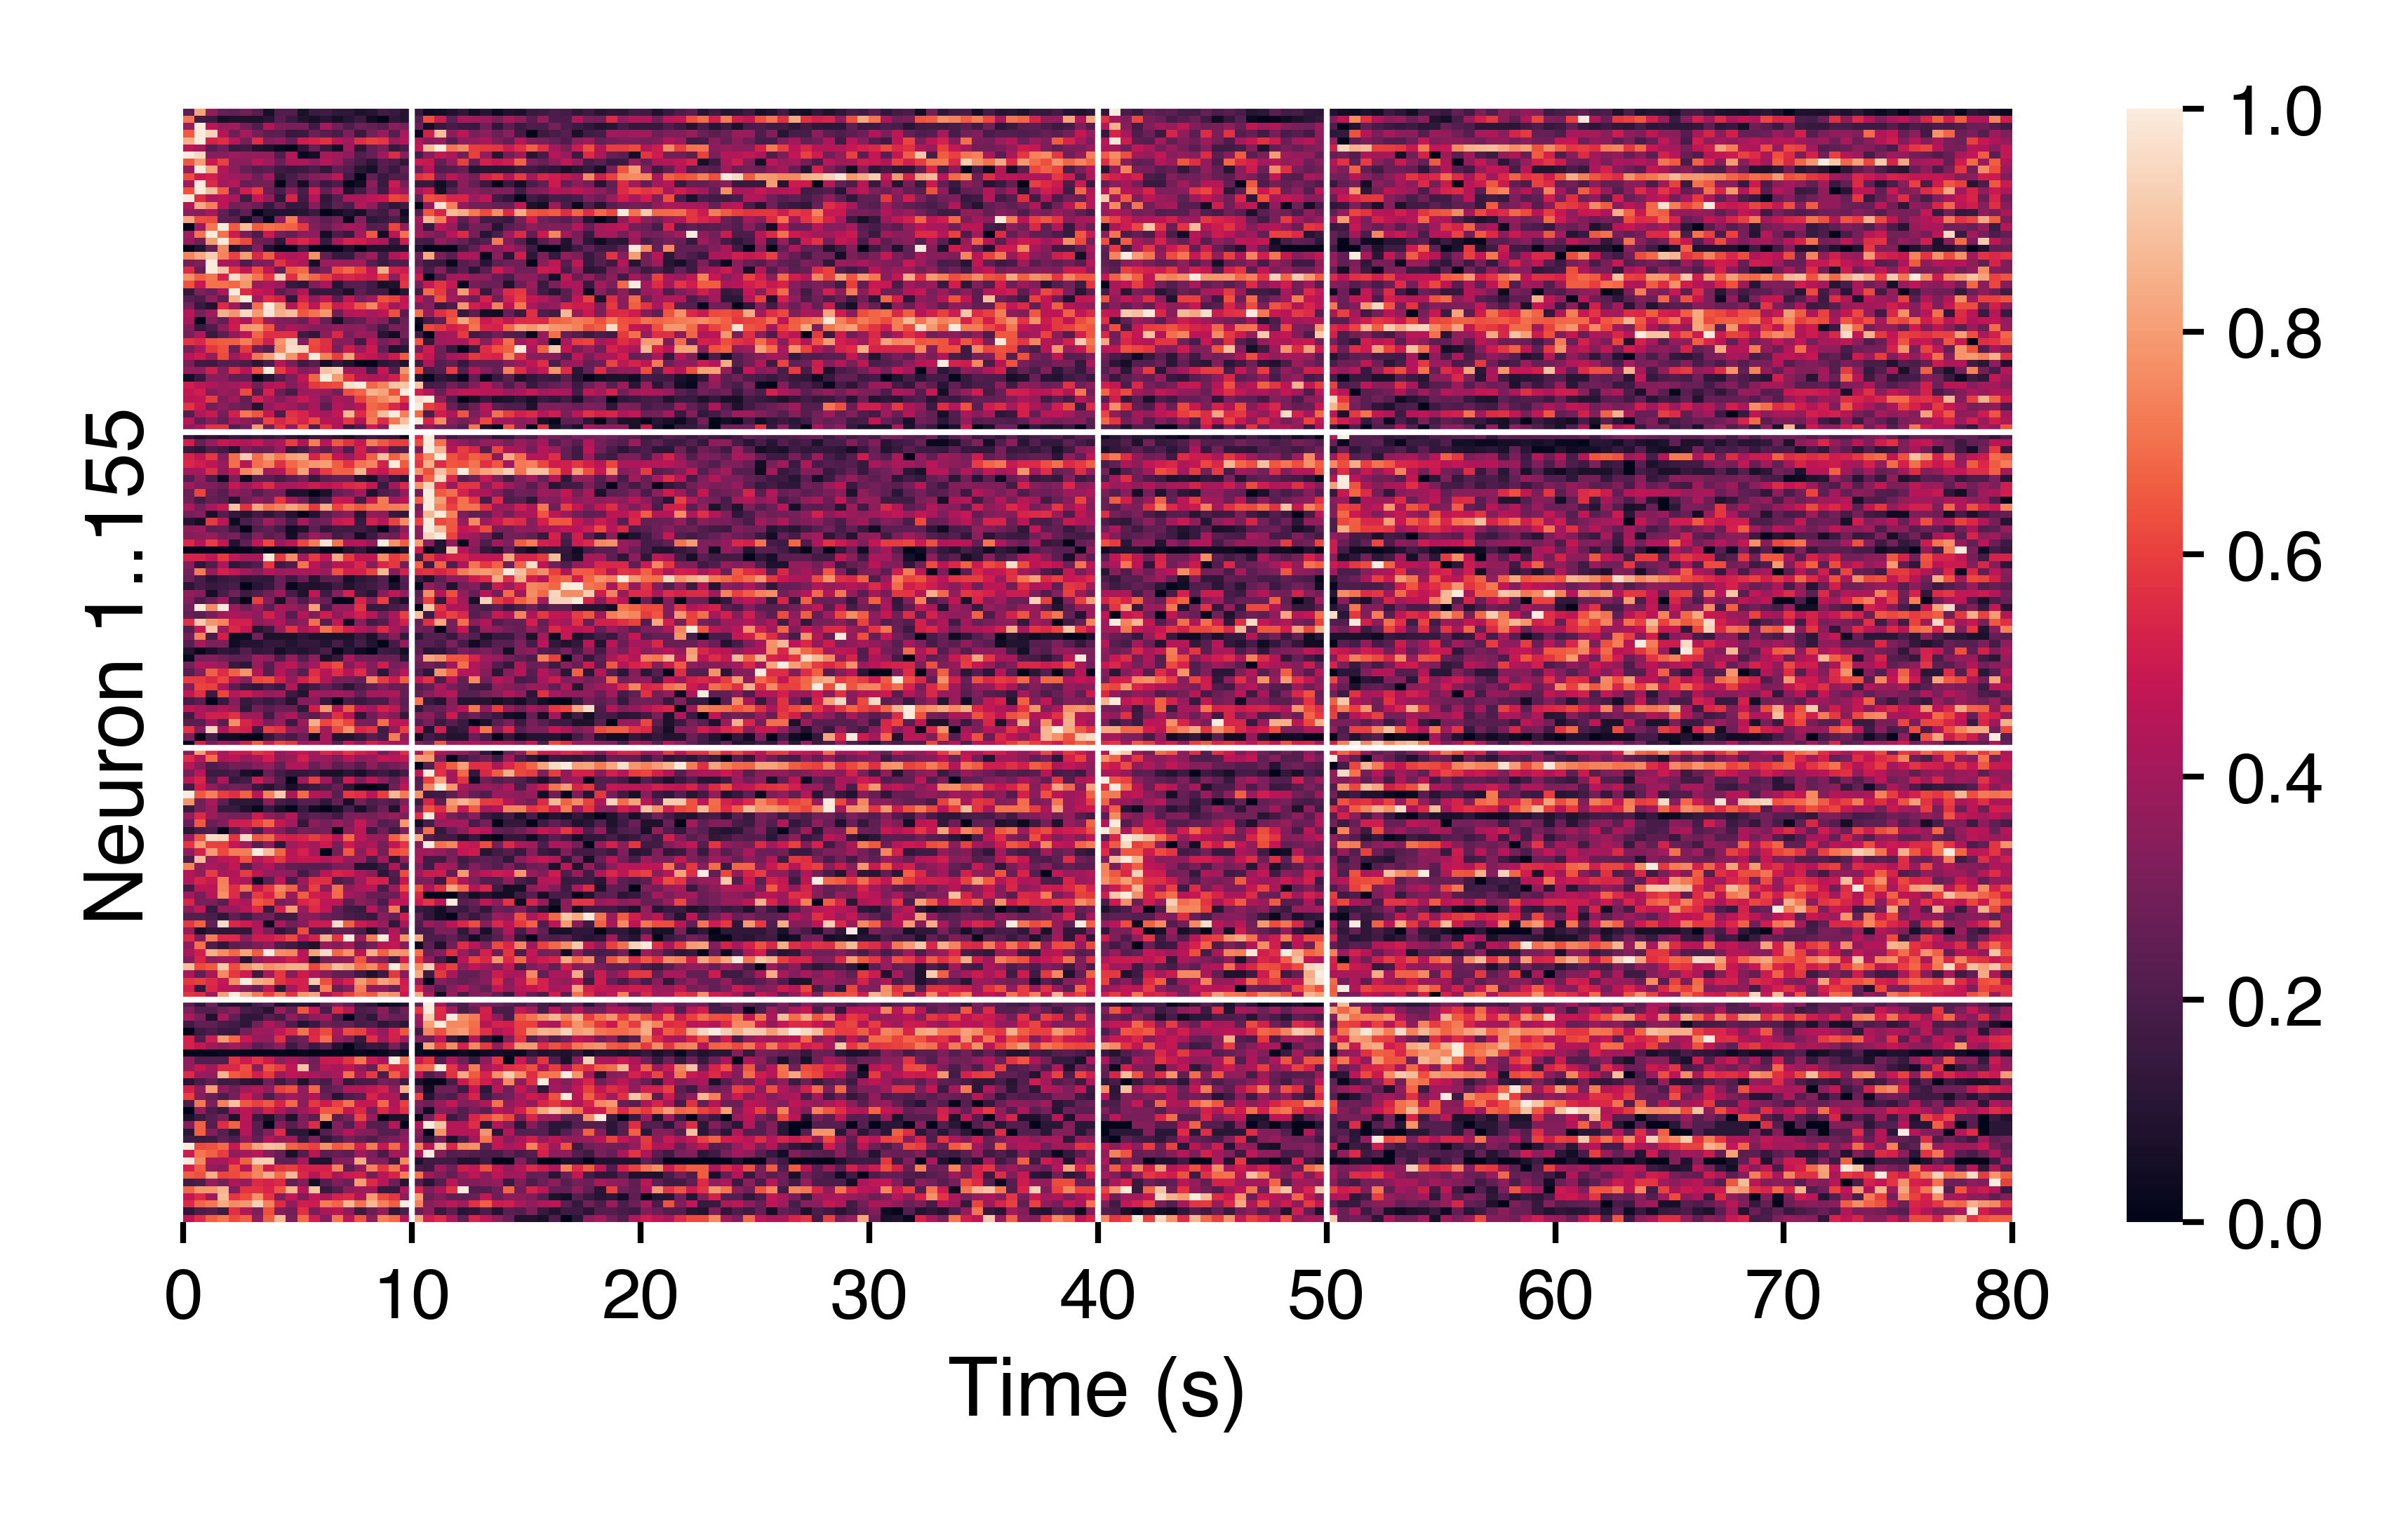

In [335]:
# Plot mean firing rates over time for all time cells, across all 4 trial intervals.
time_step_size = 500
savefig = 1
overwrite = 1
figsize = (colws['nat1w'], colws['nat1w']/2)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
vlines = np.array([0, 10, 40, 50, 80]) * (1000 / time_step_size)
vmin = 0
vmax = 1
add_cbar = True
cbar_ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])
tickpad = 2
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
xlinewidth = 0.5

plt.close()
fig, ax = plt.subplots(1, 1, dpi=dpi, figsize=figsize)
ax = np.ravel(ax)

# Get data to plot.
all_time_cells = (ols_pairs
                  .query("(testvar=='time') & (sig==True) & (beta_abs_max>0)")
                  .sort_values('z_lr', ascending=0)
                  .drop_duplicates('subj_sess_unit')
                  .sort_values(['gameState', 'beta_abs_argmax', 'z_lr'], ascending=[1, 1, 0])
                  .reset_index(drop=True)['subj_sess_unit'].values)
mean_frs = minmax_scale(pop_spikes
                        .combine_time_bins(time_step_size=time_step_size)
                        .groupby(['iGameStateTime'], observed=True)
                        [all_time_cells].mean().T.values, axis=1) # neuron x time
mat = mean_frs
n_neurons, n_time_steps = mat.shape
xticks = np.arange(0, n_time_steps+1, 10/(80/n_time_steps), dtype=int)
xticklabels = [int(x) for x in (xticks * (80/n_time_steps))]
hlines = [0] + np.cumsum(ols_pairs
                         .query("(testvar=='time') & (sig==True) & (beta_abs_max>0)")
                         .sort_values('z_lr', ascending=0)
                         .drop_duplicates('subj_sess_unit')
                         .groupby('gameState').size()).tolist()

# Make heatmap.
iax = 0
ax[iax] = sns.heatmap(mat, vmin=vmin, vmax=vmax, cbar=add_cbar, ax=ax[iax])
ax[iax].hlines(hlines[1:-1], 0, n_time_steps, colors='w', linewidths=xlinewidth)
ax[iax].vlines(np.array(vlines)[1:-1], 0, n_neurons, colors='w', linewidths=xlinewidth)
ax[iax].tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
_xticks = xticks
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels, rotation=0)
ax[iax].set_yticks([])
ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylabel('Neuron 1..{}'.format(n_neurons), fontsize=font['label'], labelpad=labelpad)
if add_cbar:
    cbar = ax[iax].collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticks)

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_remapping', 
                       'mean_firing_rates_over_time-{}timebins-{}_time_cells-{}units.pdf'.format(n_time_steps, len(all_time_cells), pop_spikes.neurons.size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight')

fig.show()

In [74]:
mean_frs.T.values#.shape

array([[48., 13., 12., ..., 30., 50., 35.],
       [62., 50., 46., ..., 33., 34., 38.],
       [18.,  8.,  8., ..., 19., 18., 15.],
       ...,
       [23., 12., 40., ..., 31., 15., 14.],
       [ 9., 10., 17., ..., 15., 42., 26.],
       [24., 43., 42., ..., 29., 34., 44.]])

In [18]:
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']

mean_frs = np.concatenate([ols_pairs.query("(testvar=='time') & (subj_sess_unit=={}) & (gameState=='{}')".format(all_time_cells, game_state))['mean_frs'].tolist()
                           for game_state in game_states], axis=1)